# MoodWave: Voice-Driven Emotion Detection

## Data Guidelines

Your dataset must be:

- Appropriate for classification. It should have a categorical outcome or the data needed to engineer one.

- Usable to solve a specific business problem. This solution must rely on your classification model.

- Somewhat complex. It should contain a minimum of 1000 rows and 10 features.

- Unfamiliar. It can't be one we've already worked with during the course or that is commonly used for demonstration purposes (e.g. Titanic).

- Manageable. Stick to datasets that you can model using the techniques introduced in Phase 3.


### Phase 3 Concepts used in this project:

- Logistic Regression:

> Logistic regression is a fundamental classification algorithm that's well-suited for binary and multiclass classification tasks. It's a good choice if your dataset has clear decision boundaries.

- Decision Trees:

> Decision trees are versatile and interpretable models that can handle both categorical and continuous data. They are particularly useful when you want to understand the decision-making process of your model.

- Evaluation Metrics (Confusion Matrices, ROC Curves, AUC):

> These metrics are essential for assessing the performance of your classification model. They will help you understand how well your model distinguishes between different emotional states.

- Hyperparameter Tuning and Pruning:

> When using decision trees, tuning hyperparameters and pruning are important to avoid overfitting and to ensure your model generalizes well to new data.

## Data Preperation

Here 4 most popular datasets in English: Crema, Ravdess, Savee and Tess. Each of them contains audio in .wav format with some main labels.

Because our data isn't inherinantly in a csv / dataframe format, we will have to create it from scratch!

First, we will pull all data into their own dataframe, making note of *where* the file is, so we can pull our features from each audio file:

- Mel-frequency cepstral coefficients (MFCCs)
- Spectral centroid
- Chroma features
- Zero-crossing rate
- RMS energy
- Pitch

And then of course, our target feature: **Emotion**

In [22]:
import pandas as pd
import numpy as np
import warnings
import zipfile
import librosa
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
# data is zipped, and stored in folders for which dataset they came from:

# Define the path to the zipped dataset
zip_file_path = 'dataset.zip'
extracted_folder_path = 'dataset'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Crema
# Ravdess
# Savee
# Tess

In [3]:
# Define the path to the Crema folder
crema_folder_path = os.path.join(extracted_folder_path, 'Crema')

# Verify that we can access the files and extract emotion labels
data = []

# Loop through each file in the Crema folder
for file_name in os.listdir(crema_folder_path):
    if file_name.endswith('.wav'):
        # Extract the emotion label from the filename
        parts = file_name.split('_')
        emotion_code = parts[2]
        
        # Map the emotion code to the actual emotion label
        emotion_map = {
            'SAD': 'sadness',
            'ANG': 'angry',
            'DIS': 'disgust',
            'FEA': 'fear',
            'HAP': 'happy',
            'NEU': 'neutral'
        }
        emotion_label = emotion_map.get(emotion_code, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({'filename': file_name, 'emotion': emotion_label, 'path': crema_folder_path})

# Convert the data into a DataFrame for easy access
df_crema = pd.DataFrame(data)

# Display the first few rows to verify
print(df_crema.head())

              filename  emotion           path
0  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [4]:
# Define the path to the Tess folder
tess_folder_path = os.path.join(extracted_folder_path, 'Tess')

# Prepare to store the data
data = []

# Loop through each emotion folder in the Tess directory
for emotion_folder in os.listdir(tess_folder_path):
    # Get the full path to the emotion folder
    emotion_folder_path = os.path.join(tess_folder_path, emotion_folder)
    
    # Extract the emotion from the folder name (e.g., "OAF_angry" -> "angry")
    emotion_label = emotion_folder.split('_')[1]
    
    # Loop through each file in the emotion folder
    for file_name in os.listdir(emotion_folder_path):
        if file_name.endswith('.wav'):
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': emotion_folder_path
            })

# Convert the data into a DataFrame for easy access
df_tess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_tess.head())

             filename emotion                    path
0  OAF_back_angry.wav   angry  dataset\Tess\OAF_angry
1   OAF_bar_angry.wav   angry  dataset\Tess\OAF_angry
2  OAF_base_angry.wav   angry  dataset\Tess\OAF_angry
3  OAF_bath_angry.wav   angry  dataset\Tess\OAF_angry
4  OAF_bean_angry.wav   angry  dataset\Tess\OAF_angry


In [5]:
# Define the path to the Savee folder
savee_folder_path = os.path.join(extracted_folder_path, 'Savee')

# Prepare to store the data
data = []

# Define the emotion mapping based on the prefixes
emotion_map = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

# Loop through each file in the Savee folder
for file_name in os.listdir(savee_folder_path):
    if file_name.endswith('.wav'):
        # Extract the prefix from the filename to determine the emotion
        prefix = file_name.split('_')[1][:2]
        
        # Map the prefix to the corresponding emotion
        emotion_label = emotion_map.get(prefix, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({
            'filename': file_name, 
            'emotion': emotion_label, 
            'path': savee_folder_path
        })

# Convert the data into a DataFrame for easy access
df_savee = pd.DataFrame(data)

# Display the first few rows to verify
print(df_savee.head())

     filename  emotion           path
0  DC_a01.wav  unknown  dataset\Savee
1  DC_a02.wav  unknown  dataset\Savee
2  DC_a03.wav  unknown  dataset\Savee
3  DC_a04.wav  unknown  dataset\Savee
4  DC_a05.wav  unknown  dataset\Savee


In [6]:
# Define the path to the Ravdess folder
ravdess_folder_path = os.path.join(extracted_folder_path, 'Ravdess', 'audio_speech_actors_01-24')

# Prepare to store the data
data = []

# Define the emotion mapping based on the third component in the filename
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Loop through each actor's folder in the Ravdess directory
for actor_folder in os.listdir(ravdess_folder_path):
    actor_folder_path = os.path.join(ravdess_folder_path, actor_folder)
    
    # Loop through each file in the actor's folder
    for file_name in os.listdir(actor_folder_path):
        if file_name.endswith('.wav'):
            # Extract the third component from the filename to determine the emotion
            emotion_code = file_name.split('-')[2]
            
            # Map the emotion code to the corresponding emotion label
            emotion_label = emotion_map.get(emotion_code, 'unknown')
            
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': actor_folder_path
            })

# Convert the data into a DataFrame for easy access
df_ravdess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_ravdess.head())

                   filename  emotion  \
0  03-01-01-01-01-01-01.wav  neutral   
1  03-01-01-01-01-02-01.wav  neutral   
2  03-01-01-01-02-01-01.wav  neutral   
3  03-01-01-01-02-02-01.wav  neutral   
4  03-01-02-01-01-01-01.wav     calm   

                                                path  
0  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
1  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
2  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
3  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
4  dataset\Ravdess\audio_speech_actors_01-24\Acto...  


### Combining datasets 

We will merge the datsets into one dataframe, and assign unique identifiers
- Concatenate the DataFrames for each dataset.
- Assign a unique ID to each entry based on the dataset.

In [7]:
# Add a unique ID column to each dataset
df_crema['id'] = ['c_{:04d}'.format(i + 1) for i in range(len(df_crema))]
df_tess['id'] = ['t_{:04d}'.format(i + 1) for i in range(len(df_tess))]
df_savee['id'] = ['s_{:04d}'.format(i + 1) for i in range(len(df_savee))]
df_ravdess['id'] = ['r_{:04d}'.format(i + 1) for i in range(len(df_ravdess))]

# Merge the datasets into a single DataFrame
merged_data = pd.concat([df_crema, df_tess, df_savee, df_ravdess], ignore_index=True)

# Reorder columns to have 'id' as the first column
merged_data = merged_data[['id', 'filename', 'emotion', 'path']]

# Display the first few rows of the combined DataFrame
print(merged_data.head())

       id             filename  emotion           path
0  c_0001  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  c_0002  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  c_0003  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  c_0004  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  c_0005  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [8]:
# remember, we need at least 1000 rows to meet our requirements. 
print(f"Total rows in dataset: {merged_data.shape[0]}")

Total rows in dataset: 12162


### Extracting Features

Again, these are the features we will extract:

- **Mel-frequency cepstral coefficients (MFCCs):** Represents the short-term power spectrum of sound, commonly used in speech and audio processing to capture the timbral texture of audio.
- **Spectral centroid:** Indicates the "center of mass" of the spectrum and is often associated with the perceived brightness of a sound.
- **Chroma features:** Represents the 12 different pitch classes and captures harmonic and melodic characteristics of music / voice.
- **Zero-crossing rate:** Measures the rate at which the signal changes sign, giving insight into the noisiness or percussiveness of the sound.
- **RMS energy:** Reflects the root mean square of the audio signal and indicates the energy or loudness of the sound.
- **Pitch:** Refers to the perceived frequency of a sound, determining how high or low a sound is.

We will be using the `librosa` package to process these audio features. [Here](https://librosa.org/doc/latest/index.html) is a link to the librosa documentation.

**Note**: adding suppression for *UserWarning: Trying to estimate tuning from empty frequency set*. This is likely do to either:* **silence / low energy** (too quiet to perform reliable pitch estimation), or the file had **too short of a duration**. This warning shows up even when setting the pitch to 0 in this case.


In [9]:
def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Check if the audio file is empty
    if len(y) == 0:
        print(f"Warning: The file {file_path} is empty.")
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)  # Return NaN for all features

    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else np.nan  # Handle case where pitch extraction fails

    # Return features as a tuple
    return (mfccs_mean, spectral_centroid, chroma, zero_crossing_rate, rms, pitch)

In [10]:
# testing our extract_features function:
first_row = merged_data.iloc[0]
file_path = os.path.join(first_row['path'], first_row['filename'])

# Extract features
features = extract_features(file_path)

# Print out each feature with its corresponding values
print("MFCCs Mean:", features[0])  # Changed to MFCCs Mean
print("Spectral Centroid:", features[1])
print("Chroma Features:", features[2])
print("Zero-Crossing Rate:", features[3])
print("RMS Energy:", features[4])
print("Pitch:", features[5])

MFCCs Mean: [-306.0274       92.670235      8.491312     23.965403      7.4779935
   -5.759455    -11.883088     -9.676736     -3.9967465   -13.352565
    0.40819725   -9.709486     -6.1271243 ]
Spectral Centroid: [1584.99307033]
Chroma Features: [0.37491405 0.37949282 0.41722107 0.39018238 0.4148401  0.2977837
 0.28898865 0.3575554  0.35190624 0.42918485 0.6879576  0.5454907 ]
Zero-Crossing Rate: [0.10186768]
RMS Energy: [0.04198619]
Pitch: 1211.9507


### Validating the Values:

- **MFCCs:** Typically, MFCC values range from -400 to 400, depending on the scale of the input signal.
> All values: **pass**

- **Spectral Centroid:** This value represents the "center of mass" of the spectrum and typically ranges between 0 and the - Nyquist frequency (half the sampling rate).
> 1584.99: **pass**

- **Chroma Features:** These represent the energy distribution across 12 pitch classes. They are normalized, so values between 0 and 1 are expected.
> All values: **pass**

- **Zero-Crossing Rate:** This rate indicates how frequently the signal changes sign. It ranges from 0 to 1. 
> 0.1018: **pass**

- **RMS Energy:** This value should be within the range of 0 to 1 for normalized signals.
> 0.0419: **pass**

- **Pitch:** Pitch values are measured in Hz, and depends on the type of audio.
> 1211.95: **pass**

Now that we've validated our extract_features function, we can apply it to the rest of our dataframe.

**Notes**: 
- This cell can take a while to run! About 5 minutes
- suppressed UserWarning: Trying to estimate tuning from empty frequency set. 

In [11]:
# Empty lists to store features
mfccs_mean_list = []
spectral_centroid_list = []
chroma_list = []
zero_crossing_rate_list = []
rms_list = []
pitch_list = []

# Iterate over each row in the DataFrame
for index, row in merged_data.iterrows():
    file_path = os.path.join(row['path'], row['filename'])
    features = extract_features(file_path)
    
    # Append the features to their respective lists
    mfccs_mean_list.append(features[0])
    spectral_centroid_list.append(features[1])
    chroma_list.append(features[2])
    zero_crossing_rate_list.append(features[3])
    rms_list.append(features[4])
    pitch_list.append(features[5])

# Add the features to the DataFrame
merged_data['mfccs'] = mfccs_mean_list
merged_data['spectral_centroid'] = spectral_centroid_list
merged_data['chroma'] = chroma_list
merged_data['zero_crossing_rate'] = zero_crossing_rate_list
merged_data['rms'] = rms_list
merged_data['pitch'] = pitch_list

# Check for any NaN values in the DataFrame
print(merged_data.isnull().sum())

H:\Anaconda\envs\learn-env\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


id                    0
filename              0
emotion               0
path                  0
mfccs                 0
spectral_centroid     0
chroma                0
zero_crossing_rate    0
rms                   0
pitch                 1
dtype: int64


In [12]:
merged_data['pitch'] = merged_data['pitch'].fillna(0)
merged_data.head()

,id,filename,emotion,path,mfccs,spectral_centroid,chroma,zero_crossing_rate,rms,pitch
0,c_0001,1001_DFA_ANG_XX.wav,angry,dataset\Crema,"[-306.0274, 92.670235, 8.491312, 23.965403, 7....",[1584.9930703294388],"[0.37491405, 0.37949282, 0.41722107, 0.3901823...",[0.10186767578125],[0.041986194],1211.950684
1,c_0002,1001_DFA_DIS_XX.wav,disgust,dataset\Crema,"[-346.39963, 95.83912, 10.516282, 31.619215, 1...",[1531.650486749737],"[0.47289878, 0.4768195, 0.33598945, 0.34610763...",[0.09306105522260275],[0.015996357],1256.617188
2,c_0003,1001_DFA_FEA_XX.wav,fear,dataset\Crema,"[-321.42026, 94.76091, 8.155397, 23.323242, 11...",[1489.0888388536061],"[0.3272673, 0.39935032, 0.35215598, 0.38248017...",[0.08428596047794118],[0.045776337],992.574402
3,c_0004,1001_DFA_HAP_XX.wav,happy,dataset\Crema,"[-303.30374, 92.52889, 4.231231, 27.970133, 10...",[1555.37603547111],"[0.3150873, 0.31478375, 0.30918238, 0.3423785,...",[0.0848781779661017],[0.042300183],1102.953003
4,c_0005,1001_DFA_NEU_XX.wav,neutral,dataset\Crema,"[-335.4959, 100.39331, 9.384935, 30.160904, 11...",[1495.3949968411737],"[0.4112704, 0.36269408, 0.3349767, 0.32547352,...",[0.08203125],[0.020449637],1041.093628


We won't be able to work with arrays - we will need to extract a meaningful metric and save them in a new column.

In [13]:
# Create a new DataFrame for the cleaned features
clean_data = pd.DataFrame()

# Store the mean of array values and existing values for non-array columns
clean_data['mfccs_mean'] = merged_data['mfccs'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['spectral_centroid'] = merged_data['spectral_centroid'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['chroma'] = merged_data['chroma'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['zero_crossing_rate'] = merged_data['zero_crossing_rate'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['rms'] = merged_data['rms'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['pitch'] = merged_data['pitch']  # Directly store the existing value

# Add the emotion column
clean_data['emotion'] = merged_data['emotion']

# Display the new DataFrame
print(clean_data.head())

   mfccs_mean  spectral_centroid    chroma  zero_crossing_rate       rms  \
0  -17.963037        1584.993070  0.411293            0.101868  0.041986   
1  -18.657297        1531.650487  0.423961            0.093061  0.015996   
2  -18.552622        1489.088839  0.413398            0.084286  0.045776   
3  -18.460817        1555.376035  0.394820            0.084878  0.042300   
4  -18.111607        1495.394997  0.401279            0.082031  0.020450   

         pitch  emotion  
0  1211.950684    angry  
1  1256.617188  disgust  
2   992.574402     fear  
3  1102.953003    happy  
4  1041.093628  neutral  


In [14]:
# Check for any NaN values in the DataFrame
print(clean_data.isnull().sum())

mfccs_mean            0
spectral_centroid     0
chroma                0
zero_crossing_rate    0
rms                   0
pitch                 0
emotion               0
dtype: int64


## Building a Model

In [34]:
X = clean_data[['mfccs_mean', 'spectral_centroid', 'chroma', 'zero_crossing_rate', 'rms', 'pitch']]
y = clean_data['emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

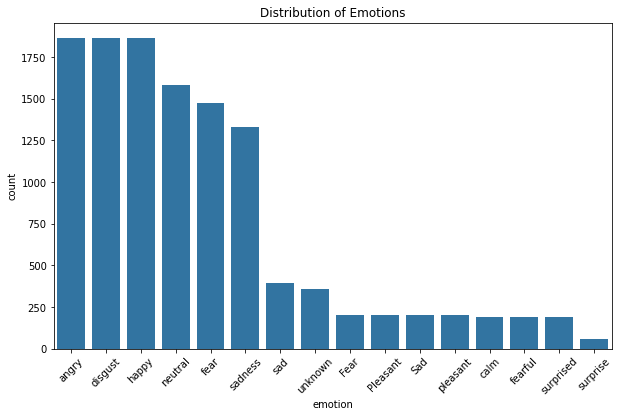

In [15]:
# distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

# this chart shows some a significant imbalance in the dataset. lets do some resampling
# Lets try using the SMOTE technique (Synthetic Minority Over-sampling):

In [40]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Verify the new distribution of the training data
from collections import Counter
print("Original dataset shape:", Counter(y))
print()
print("Resampled dataset shape:", Counter(y_smote))

Original dataset shape: Counter({'angry': 1863, 'disgust': 1863, 'happy': 1863, 'neutral': 1583, 'fear': 1471, 'sadness': 1331, 'sad': 392, 'unknown': 360, 'Fear': 200, 'Pleasant': 200, 'Sad': 200, 'pleasant': 200, 'calm': 192, 'fearful': 192, 'surprised': 192, 'surprise': 60})

Resampled dataset shape: Counter({'angry': 1863, 'disgust': 1863, 'fear': 1863, 'happy': 1863, 'neutral': 1863, 'sadness': 1863, 'Fear': 1863, 'Pleasant': 1863, 'Sad': 1863, 'pleasant': 1863, 'sad': 1863, 'unknown': 1863, 'surprise': 1863, 'calm': 1863, 'fearful': 1863, 'surprised': 1863})


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Create and fit the model with scaled data
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_log_reg = log_reg.predict(X_test_scaled) # Use scaled test data

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))

Logistic Regression Accuracy: 0.5689365984568937
Confusion Matrix:
 [[345  25   0   0   0   0   0   0   0   0  20   5   0   0   2   0]
 [ 21 340  13   0   0   5   0   0   0   3   8   0   0   0   0   0]
 [  0   5 349   0   0   0   0   0   0   9   0   0   0   0   0   0]
 [ 27  14   0 144   5  14  86  19   3   4  25   9   7   0  12   0]
 [  0   0   0   0 296   0   0   6   0   0   0  25   0   0  29   0]
 [  0  32  11   8  18  66  62   5   3  42  33   5 102   0  11   0]
 [  1   0   0  72   0  36  74   0  10  35  17   1  96   0   0   0]
 [  2   0   0   5  34   1   0 218   0   0   0  22   0   0  79   0]
 [ 16  29   0  47   4  34 117  13  10  19  14   7  58   0  11   0]
 [  3   4  52   3  17  34  47   0   4  59  15  15 118   0   2   0]
 [  1   2   0   3   0   1   0   0   7   0 374   1   0   0   0   0]
 [  2   0   0  30  79   3   2  26  11   3  15 156   0   0  43   0]
 [  1   0   0   1   0  29  11   0   0  52   0   0 256   1   0  23]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 258   0

In [44]:
# Create and fit the model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_scaled, y_train)

# Make predictions
y_pred_tree = decision_tree.predict(X_test_scaled)

# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.7115062059711507
Confusion Matrix:
 [[373   1   0  16   0   1   0   1   2   0   2   0   0   0   0   1]
 [  2 366   5   1   0   4   0   0   8   4   0   0   0   0   0   0]
 [  0   1 339   0   0   2   0   0   1  20   0   0   0   0   0   0]
 [ 19   1   0 177   3  25  48  10  61   5   6   2   2   0  10   0]
 [  0   0   0   0 309   4   0   3   2  13   0  20   0   0   5   0]
 [  0  15   6  29  10 119  52   9  37  54   1   5  54   0   7   0]
 [  0   0   0  40   0  44 138   0  39  39   2   0  40   0   0   0]
 [  0   0   0   7   2   6   0 308  10   0   1  12   0   0  15   0]
 [  9  15   1  51   2  42  51   7 122  39   1   7  25   0   7   0]
 [  1   4  24  15   8  44  35   2  34 147   4   6  44   0   5   0]
 [  0   0   0   8   0   8   2   0   0   0 370   1   0   0   0   0]
 [  0   0   0   1  23   8   1  10   2   9   1 296   0   0  19   0]
 [  0   0   0   1   0  46  51   0  20  48   0   0 193   1   0  14]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1 352   0  24]


In [45]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Review the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best_tree = best_model.predict(X_test_scaled)

# Evaluate the best model
print("Decision Tree Accuracy (Best):", accuracy_score(y_test, y_pred_best_tree))
print("Confusion Matrix (Best):\n", confusion_matrix(y_test, y_pred_best_tree))
print("Classification Report (Best):\n", classification_report(y_test, y_pred_best_tree))

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 644 out of 675 | elapsed:    9.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:    9.8s finished


Best parameters found:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score:  0.6942045961580139
Decision Tree Accuracy (Best): 0.7093257296209325
Confusion Matrix (Best):
 [[378   2   0  10   0   0   0   1   2   0   2   2   0   0   0   0]
 [  1 367   4   1   0   7   0   0   4   5   1   0   0   0   0   0]
 [  0   0 350   0   0   5   0   0   0   8   0   0   0   0   0   0]
 [ 18   3   0 188   3  34  34  10  54   7   4   4   3   0   7   0]
 [  0   0   0   0 319   3   0   2   0   6   0  19   0   0   6   1]
 [  0  15   6  24   9 128  50   9  47  53   3   9  40   0   5   0]
 [  0   0   0  38   0  32 136   0  55  33   0   1  47   0   0   0]
 [  1   0   0   9   6   5   0 289   9   2   0  15   0   0  25   0]
 [ 10  13   2  63   2  43  57   9 109  45   0   6  16   0   4   0]
 [  0   4  42  12   9  51  31   2  36 135   4  11  33   0   3   0]
 [  1   0   0   2   0   2   1   1   0   2 379   1   0   0   0   0]
 [  0   1   0   1  30   8

## Evaluating the Models
The decision tree and grid search-tuned decision trees were our best models.

### Accuracy:
- Both models have an accuracy of 71% , which isn't bad (but could certainly be better)

### Precision, Recall, F1-Score
- Very similar scores from both models, but the grid search model has slightly better performance for the 'Sad' class
   (F1-score of .92)
   
### Strengths:
- performs well on several classes: **fear**, **pleasant**, **calm**
    all with f1-scores over .85

### Weaknesses:
- performs poorly on classes: **angry**, **disgust**, **fear**, **happy**, **neutral**
    with f1-scores around .30 - .52
    
This means we are on the right track, but there is still room for improvement. 

## Exploratory Visualizations



In [20]:
emotion_distribution = clean_data['emotion'].value_counts()
print(emotion_distribution)

emotion
angry        1863
disgust      1863
happy        1863
neutral      1583
fear         1471
sadness      1331
sad           392
unknown       360
Fear          200
Pleasant      200
Sad           200
pleasant      200
calm          192
fearful       192
surprised     192
surprise       60
Name: count, dtype: int64


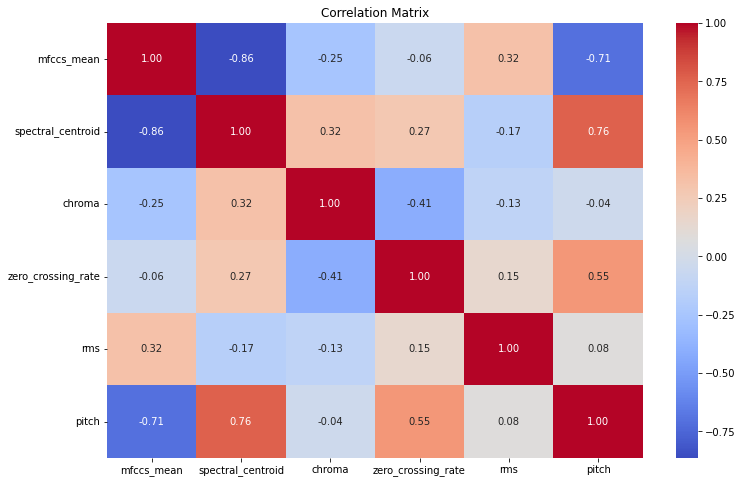

In [16]:
# correlation matrix

# Select only numeric columns for correlation matrix
numeric_data = clean_data.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

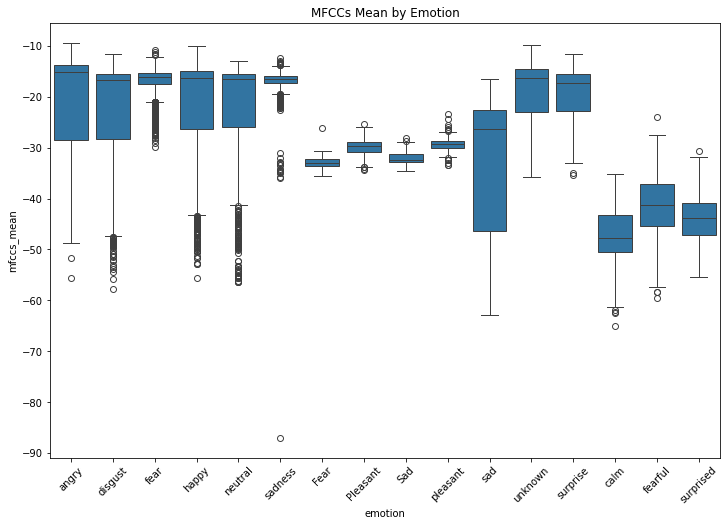

In [17]:
# box plots of features by emotion
plt.figure(figsize=(12, 8))
sns.boxplot(data=clean_data, x='emotion', y='mfccs_mean')
plt.title('MFCCs Mean by Emotion')
plt.xticks(rotation=45)
plt.show()

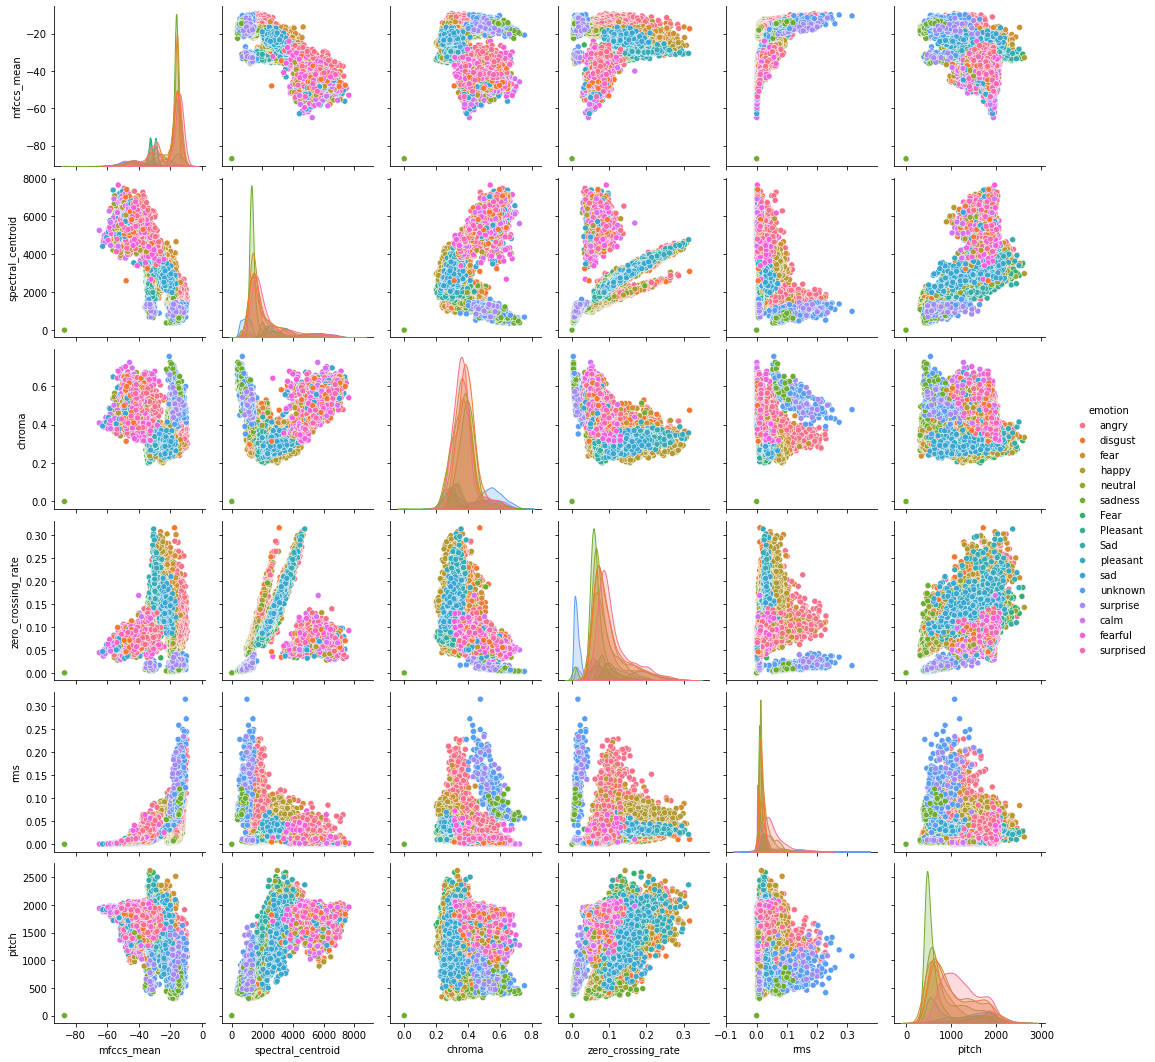

In [18]:
sns.pairplot(clean_data, hue='emotion', vars=['mfccs_mean', 'spectral_centroid', 'chroma', 'zero_crossing_rate', 'rms', 'pitch'])
plt.show()

In [19]:
# feature importance
feature_importances = decision_tree.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=clean_data.columns[:-1])  # Exclude the 'emotion' column
plt.title('Feature Importances')
plt.show()

NameError: name 'decision_tree' is not defined

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = decision_tree.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label='desired_class')  # Change 'desired_class' as needed
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(decision_tree, X_train_scaled, y_train, cv=5)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()